# Comparison

In [53]:
import time
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.font_manager as font_manager
import seaborn as sns
from cycler import cycler

from common import *

colors = {
    'Bl':(0,0,0),
    'Or':(.9,.6,0),
    'SB':(.35,.7,.9),
    'bG':(0,.6,.5),
    'Ye':(.95,.9,.25),
    'Bu':(0,.45,.7),
    'Ve':(.8,.4,0),
    'rP':(.8,.6,.7),
}

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (16, 10)

plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['axes.prop_cycle'] = cycler('color',  [colors[k] for k in ['Bl', 'Or', 'SB', 'bG', 'Ye', 'Bu', 'Ve', 'rP']])

plt.rcParams['grid.color'] = (.7, .7, .7, 0)

plt.rcParams['xtick.color'] = 'k'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.facecolor'] = 'w'
plt.rcParams['legend.edgecolor'] = (.7, .7, .7, 0)



font_prop = font_manager.FontProperties(size = 12)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)

numpy ver.: 1.12.1
pandas ver.: 0.20.1


In [8]:
def comparison_matrix(data):
    models = ['ConvLSTM', 'Historical Average', 'Current Model', 'Google Maps']
    results = pd.DataFrame(columns = ['Model', 'RMSE (min)', 'MAE (min)', 'MAPE (%)', 'SMAPE (%)'])
    for m in models:
        rmse = np.sqrt(np.mean((data['Ground Truth'] - data[m])**2))
        mae = np.mean(np.abs((data['Ground Truth'] - data[m])))
        mape = np.mean(np.abs((data['Ground Truth'] - data[m])) / data['Ground Truth']) * 100
        smape = np.mean(np.abs((data['Ground Truth'] - data[m])) / (np.abs(data['Ground Truth']) + np.abs(data[m])) / 2) * 100
        results = results.append(pd.DataFrame([[m, rmse, mae, mape, smape]], columns = results.columns), ignore_index = True)
    return results.set_index('Model')

## Load and transform ground truth

In [9]:
data = prep_data('../data/4A_1_201710.csv')
print(len(data))

38844


Links included in the evaluation, i.e. the first 32 links of 4A in the CCW direction:

In [10]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 32)]
assert len(data['LinkRef'].unique()) == 32
n = len(data)
print(n)

30272


In [11]:
means, scales, low, upr = fit_scale(data)

In [12]:
ix, ts, rm_mean, rm_scale, w, k = transform(data, means, scales)

In [13]:
ts_true = pd.DataFrame(index = ix, data = ts * rm_scale + rm_mean, columns = k)

In [14]:
ts_convlstm = pd.read_csv('../data/Output-ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.csv', index_col = 0, parse_dates = True)

##  Load comparison data
### Load prepared data for Current Model

In [15]:
ts_cm = pd.read_csv('../data/current_model/data_prepared.csv', index_col = 0, parse_dates = True)

### Load and transform Google Maps Distance Matrix

In [16]:
ts_gmaps = pd.read_csv('../data/google/data_prepared.csv', index_col = 0, parse_dates = True)

### Load and transform Historical Average

In [17]:
ha_data = prep_data('../data/4A_1_201705_201709.csv')
ha_data = ha_data[(1 <= ha_data['LineDirectionLinkOrder']) & (ha_data['LineDirectionLinkOrder'] <= 32)]
ha_means, ha_scales, ha_low, ha_upr = fit_scale(ha_data)
ha_ix, _, ha_rm_mean, _, _, _ = transform(data, ha_means, ha_scales)
ts_ha = pd.DataFrame(index = ix, data = ha_rm_mean, columns = k)

## Descriptive statistics

Collect statistics into single data frame.

In [18]:
comp = pd.DataFrame(index = ix, data = ts_true.sum(axis = 1) / 60, columns = ['Ground Truth'])
comp['ConvLSTM'] = ts_convlstm.sum(axis = 1) / 60
comp['Historical Average'] = ts_ha.sum(axis = 1) / 60
comp['Current Model'] = ts_cm.sum(axis = 1) / 60
comp['Google Maps'] = ts_gmaps.sum(axis = 1) / 60
comp['Day'] = comp.index.strftime('%A')
comp_ = comp.between_time('06:00', '23:45')

### Look at a week (06 - 00)

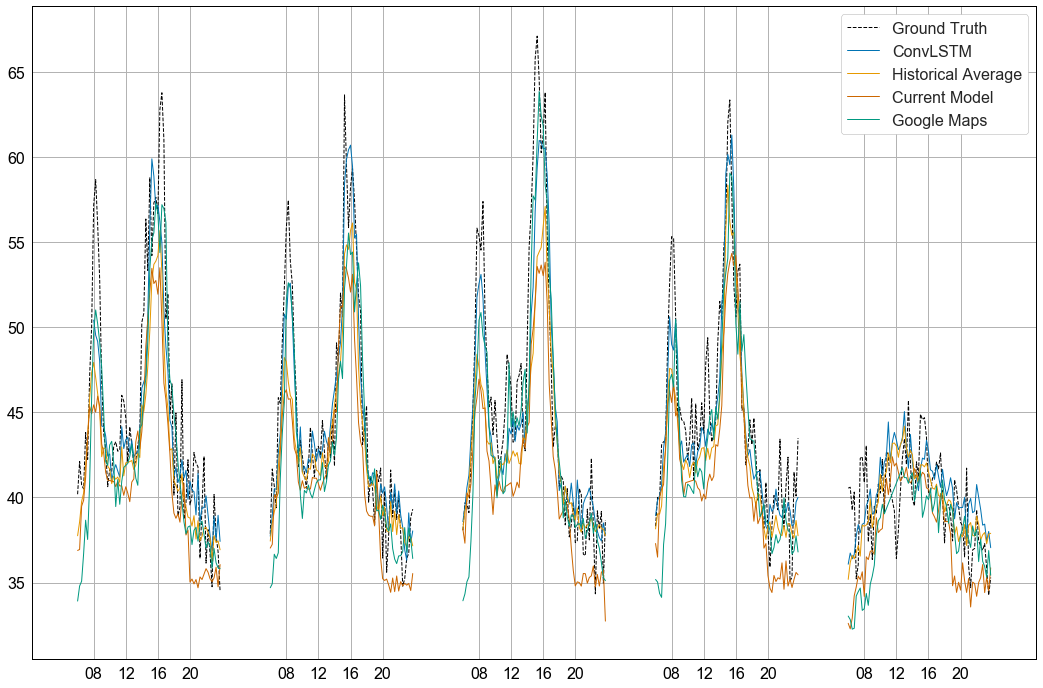

In [26]:
fig, ax = plt.subplots(figsize = (18, 12))
first = True
for key, comp_day in comp_.groupby('Day'):
    a, = plt.plot(comp_day['Ground Truth'], label = 'Ground Truth', color = 'C0', linewidth = 1, linestyle = '--')
    b, = plt.plot(comp_day['ConvLSTM'], label = 'ConvLSTM', color = 'C1', linewidth = 1, linestyle = '-')
    c, = plt.plot(comp_day['Historical Average'], label = 'Historical Average', color = 'C2', linewidth = 1, linestyle = '-')
    d, = plt.plot(comp_day['Current Model'], label = 'Current Model', color = 'C4', linewidth = 1, linestyle = '-')
    e, = plt.plot(comp_day['Google Maps'], label = 'Google Maps', color = 'C6', linewidth = 1, linestyle = '-')
    if first:
        ax.legend(handles = [a, b, c, d, e], loc='upper right')
        first = False
        
dt_ix = pd.date_range('2017-10-10 08:00', '2017-10-15', freq = '4H')
ax.set_xticks(dt_ix[dt_ix.indexer_between_time('06:00', '23:45')])
xfmt = md.DateFormatter('%H')
ax.xaxis.set_major_formatter(xfmt)


In [16]:
comparison_matrix(comp_)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,2.816300,2.156420,4.783415,1.204230
Historical Average,3.660695,2.639079,5.595210,1.449145
Current Model,4.677756,3.642846,7.821770,2.073168
Google Maps,3.635409,2.876974,6.380876,1.657978


### Look at a weekday

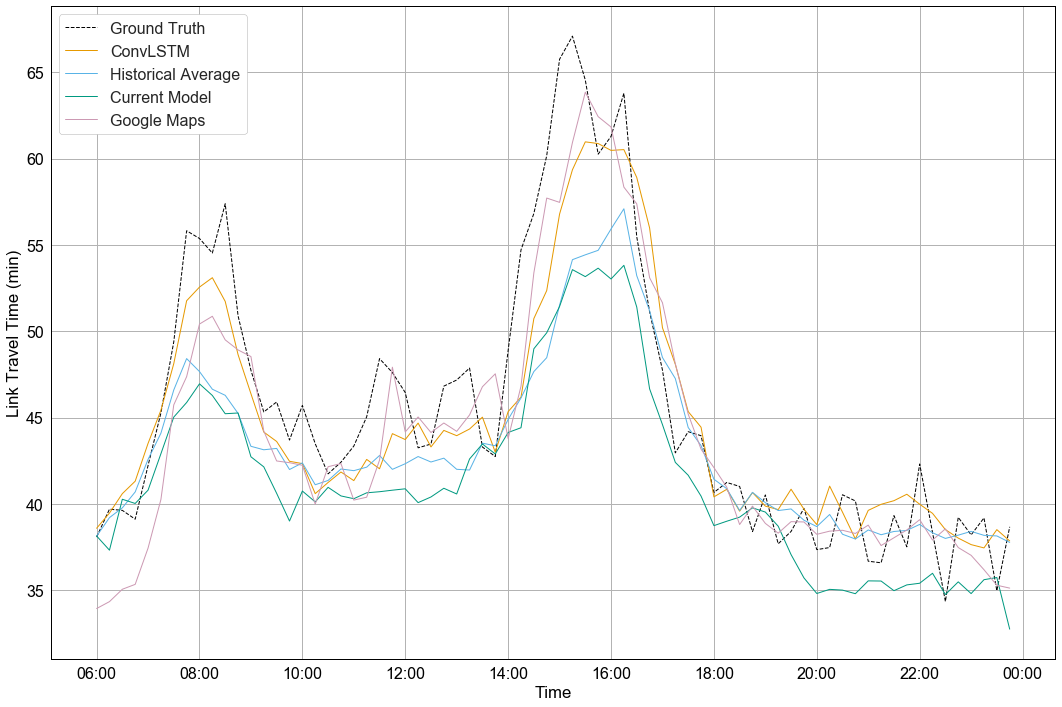

In [70]:
comp_day = comp_[comp_['Day'] == 'Thursday'].between_time('06:00', '00:00')
fig, ax = plt.subplots(figsize = (18, 12))
a, = plt.plot(comp_day['Ground Truth'], label = 'Ground Truth', color = 'C0', linewidth = 1, linestyle = '--')
b, = plt.plot(comp_day['ConvLSTM'], label = 'ConvLSTM', color = 'C1', linewidth = 1, linestyle = '-')
b, = plt.plot(comp_day['Historical Average'], label = 'Historical Average', color = 'C2', linewidth = 1, linestyle = '-')
c, = plt.plot(comp_day['Current Model'], label = 'Current Model', color = 'C3', linewidth = 1, linestyle = '-')
d, = plt.plot(comp_day['Google Maps'], label = 'Google Maps', color = 'C7', linewidth = 1, linestyle = '-')
ax.legend(loc='upper left', )

        
dt_ix = pd.date_range(min(comp_day.index), max(comp_day.index) + pd.to_timedelta('00:15:00'), freq = '2H')
ax.set_xticks(dt_ix[dt_ix.indexer_between_time('06:00', '00:00')])
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel('Time')
ax.set_ylabel('Link Travel Time (min)')

plt.savefig('../paper/plots/comparison_day.pdf', bbox_inches='tight')

In [18]:
comparison_matrix(comp_day)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,3.199186,2.473926,5.220033,1.321612
Historical Average,4.647736,3.241967,6.401941,1.679073
Current Model,5.550707,4.439592,9.031772,2.407053
Google Maps,3.482333,2.804613,6.004636,1.545035


### Between 14:00 and 18:00

In [19]:
comp_weekdays = comp_[(comp_['Day'] != 'Saturday') & (comp_['Day'] != 'Sunday')].between_time('14:00', '17:45')
comparison_matrix(comp_weekdays)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,4.102143,3.229412,5.873929,1.503035
Historical Average,5.659658,4.501155,7.990473,2.112488
Current Model,6.615273,5.536635,9.857100,2.634534
Google Maps,4.434399,3.638969,6.699855,1.721511


In [22]:
comp_weekdays = comp_[(comp_['Day'] != 'Saturday') & (comp_['Day'] != 'Sunday')].between_time('08:00', '09:45')
comparison_matrix(comp_weekdays)

,RMSE (min),MAE (min),MAPE (%),SMAPE (%)
Model,,,,
ConvLSTM,3.709005,2.891242,5.534842,1.437682
Historical Average,6.151967,5.041099,9.541683,2.556590
Current Model,6.978540,5.940269,11.367726,3.068359
Google Maps,4.127555,3.295863,6.376022,1.667862
